# 2025-04-23: Beautiful UMAPs that tickle my brain 
### By [Aishwarya Chander](aishwarya.chander@alleninstitute.org), High Resolution Translational Immunology, Allen Institute for Immunology
**Aim:** Use this notebook if you're interested in making aesthetic umaps. Peek through an [example](https://apps.allenimmunology.org/aifi/resources/imm-health-atlas/cell-type-descriptions/ ) where this was used. 

In [1]:
import matplotlib.font_manager
fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
from adjustText import adjust_text

import pandas as pd 
import numpy as np 
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


import pickle
import warnings
from datetime import date
import os
import shutil

warnings.filterwarnings("ignore")
sc.settings.n_jobs = 60
print("Current working directory:", os.getcwd())

Current working directory: /home/workspace/certpro-ndmm-bmmc-code/07-bmmc-viz


### 1. This bit of code helps compute the label distances

In [2]:
def gen_mpl_labels(
    adata, groupby, colors_df, exclude=(), ax=None, adjust_kwargs=None, 
    text_kwargs=None, offset=(0.05, 0.05)
):
    if adjust_kwargs is None:
        adjust_kwargs = {
            "arrowprops": {"arrowstyle": "->", "color": 'black'},
            "expand_points": (1.2, 1.2),
            "force_points": 0.5
        }

    highest_density_points = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        points = adata[g_idx].obsm["X_umap"]
        hist, xedges, yedges = np.histogram2d(points[:, 0], points[:, 1], bins=[50, 50])
        max_bin = np.unravel_index(np.argmax(hist), hist.shape)
        highest_density_point = [
            (xedges[max_bin[0]] + xedges[max_bin[0] + 1]) / 2 + offset[0],
            (yedges[max_bin[1]] + yedges[max_bin[1] + 1]) / 2 + offset[1]
        ]
        highest_density_points[g] = highest_density_point

    if ax is None:
        ax = plt.gca()

    texts = []
    for k, (x, y) in highest_density_points.items():
        color = colors_df.loc[colors_df['label'] == k, 'color'].values[0]
        annotation_color = colors_df.loc[colors_df['label'] == k, 'annotation_color'].values[0]
        text_kwargs = {
            'fontsize': 4.5,
            'weight': 'bold',
            'color': annotation_color,
            'bbox': dict(
                facecolor=color, edgecolor='black', linewidth=0.4, 
                boxstyle='round, pad=0.5', alpha=0.8
            )
        }
        texts.append(ax.text(x=x, y=y, s=k, **text_kwargs))

    adjust_text(texts, **adjust_kwargs)

### 2. Picks text color based background color for good contrast

In [3]:
def is_dark_color(hex_color):
    rgb = mcolors.hex2color(hex_color)
    luminance = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
    return 'white' if luminance < 0.5 else 'black'

### 3. This is my custom color scheme, replace with anything you like

In [4]:
cols_L2 = {
    # B cells (Magenta-Pink range)
    'b_precursor': '#C71585', 
    'b_naive': '#FF1493',  
    'b_memory': '#DB7093',  
    'b_transitional': '#D6336D',  

    # T cells (Blue range)
    't_cd4_memory': '#1E90FF',  
    't_cd4_naive': '#87CEFA',  
    't_cd4_regs': '#007FFF',  
    't_cd8_memory': '#104E8B',  
    't_cd8_naive': '#5CACEE',  
    't_gd': '#00868B',  
    't_mait': '#000080',  
    't_dn': '#B0E0E6',  

    # NK cells (Teal/Cyan range, distinct from monocytes)
    'nk_cd56_dim': '#2E8B57',  
    'nk_cd56_bright': '#20B2AA',  
    'nk_tissue_resident': '#008B8B',  
    'nk_t_proliferating': '#005F73',  

    # Monocytes (Greens with a brown tone for distinction from NK)
    'mono_cd14': '#6B8E23',  
    'mono_cd16': '#556B2F',  
    'mono_intermediate': '#3F704D',  

    # Dendritic Cells (DCs) (Orange-Yellow)
    'dc_cdc1': '#FFA500',  
    'dc_cdc2': '#FF8C00',  
    'dc_asdc': '#E25B00',  
    'dc_pdc': '#FF4500',  

    # Progenitors (Red/Burgundy-based)
    'prog_b': '#8B1C62',  
    'prog_hspc': '#BC8F8F',  
    'prog_cmp': '#990000',  
    'prog_clp': '#8B0A50',  
    'prog_mk': '#CD4F39',  
    'prog_lmpp': '#CD5555',  
    'prog_mep': '#B22222',  
    'prog_mature_ery': '#8B2323',  
    'prog_ery': '#A52A2A',  
    'prog_dc': '#D2691E',  

    # Mesenchymal Stem Cells (Neutrals)
    'msc_fibroblasts': '#8B7765',  
    'msc_platelet': '#A67B5B',  

    # Plasma Cells (Brick red)
    'plasma': '#614041'
}


> If you're lazy, you can extract your default colors as follows:
```python
cols_L2 = dict(zip(adata.obs['leiden'].cat.categories, adata.uns['leiden_colors']))
```

### 4. Now make your dataframe of cell type & text colors

In [5]:
colors = pd.DataFrame(list(cols_L2.items()), columns=['label', 'color'])
colors['annotation_color'] = colors['color'].apply(is_dark_color)
colors.head()

,label,color,annotation_color
0,b_precursor,#C71585,white
1,b_naive,#FF1493,white
2,b_memory,#DB7093,black
3,b_transitional,#D6336D,white
4,t_cd4_memory,#1E90FF,white


### 5. Plot and save your umap
> Make sure you run `sc.tl.umap` before this step.

In [6]:
adata = sc.read_h5ad('../../certpro-ndmm-data/ndmm-bmmc-visits-reprocessed/2025-02-26-ndmm-bmmc-mm_pre-treatment-visit-processed.h5ad')

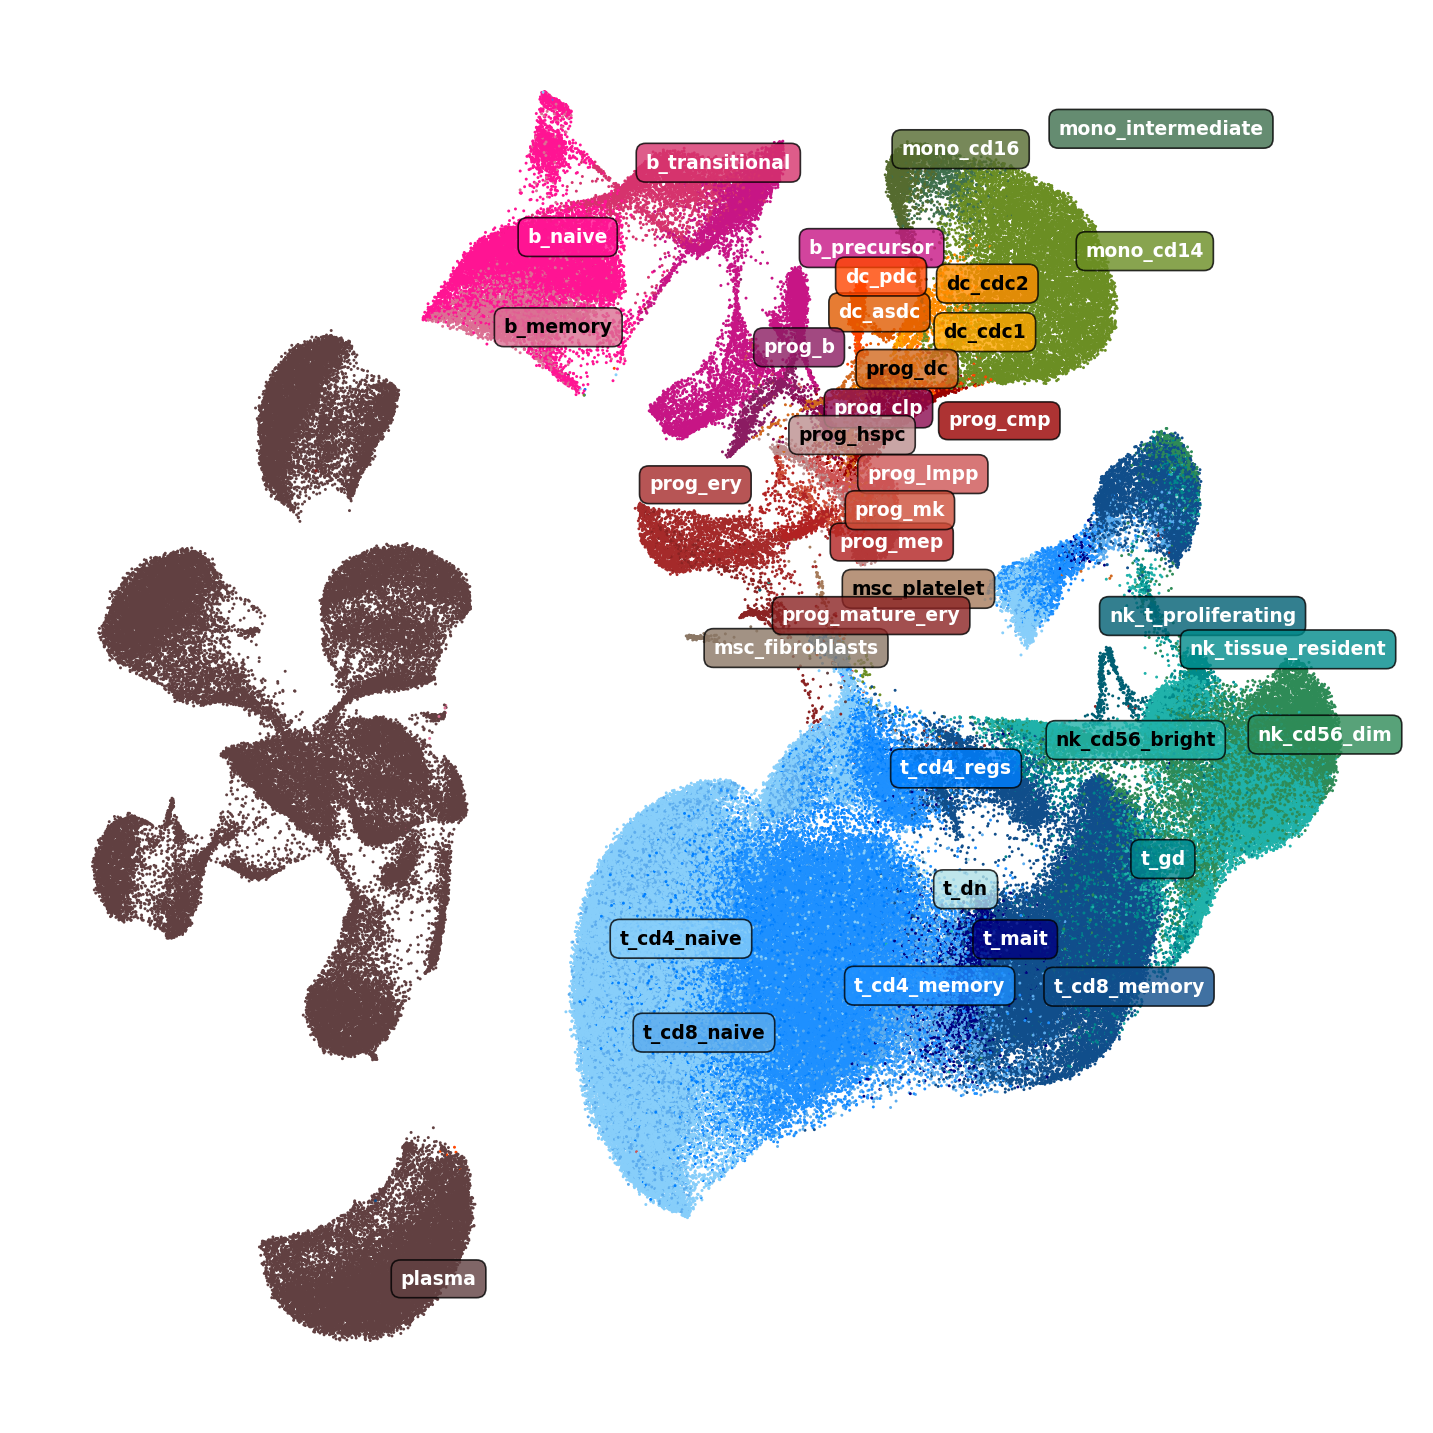

In [7]:
sc.set_figure_params(
    frameon=False, facecolor='white', figsize=(5, 5), dpi=150
)  # Adjust fig size based on your personal preference

ax = sc.pl.umap(
    adata,
    color=['manual.label_l2'],
    size=2,  # Adjust the size of each point in the UMAP; if you have few cells, use a larger value
    show=False,
    legend_loc=None,
    ncols=1,
    palette=cols_L2,
    frameon=False
)

gen_mpl_labels(
    adata,
    "manual.label_l2",
    colors,
    exclude=(""),
    ax=ax,
    adjust_kwargs=dict(arrowprops=None)
)

ax.set_title('')
fig = ax.get_figure()
fig.tight_layout()

fig.savefig('export-umap.png', format='png', dpi=150) # Output however you want

## 6. Is your code breaking?
Check for:
1. The names in the color df match the names of your umap `color` parameter.
2. Ensure that hex_color is a valid hexadecimal color string (e.g., #RRGGBB or #RGB). If the input is invalid, mcolors.hex2color will raise a ValueError.
3. ...is it a seurat object...?